In [32]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os

from importlib import reload

import small_utilities
reload(small_utilities)
import Block_analysis
reload(Block_analysis)

from Block_analysis import *
from small_utilities import *

import seaborn as sns

from scipy.stats import bootstrap


In [67]:
def reposition_first(array):
    if len(array.shape) == 2:  # Check if it's 2D
        # Reposition first row to the last
        return np.vstack((array[1:], array[0]))
    elif len(array.shape) == 3:  # Check if it's 3D
        # Reposition first slice to the last
        return np.concatenate((array[1:], array[:1]), axis=0)

import matplotlib.pyplot as plt
import numpy as np

def plot_colvar(colvar, trj_frames, num_cvs, labels, weights=None, out_dir=None):
    """
    Plot collective variables over time with corresponding histograms and reweighted histograms.

    Parameters:
        colvar (np.ndarray): Array of collective variables with time as the first column.
        trj_frames (dict): Dictionary mapping frame indices to frame times.
        num_cvs (int): Number of collective variables.
        labels (dict): Dictionary of labels for the collective variables.
        weights (np.ndarray, optional): Normalized weights for reweighting histograms. Must match the number of frames.
        out_dir (str, optional): Directory to save the plot. If None, the plot is shown but not saved.
    """
    # Configure subplots
    height_ratios = [1] * (num_cvs - 1)
    fig, axes = plt.subplots(
        num_cvs - 1, 2, figsize=(32, 40),
        gridspec_kw={
            'width_ratios': [4, 1],
            'height_ratios': height_ratios,
            'left': 0.1, 'right': 0.9,
            'bottom': 0.1, 'top': 0.9,
            'wspace': 0.02, 'hspace': 0.2
        },
        sharey=False,
        # sharex=True
    )

    # Check if weights are provided
    if weights is not None:
        if len(weights) != colvar.shape[0]:
            raise ValueError("Weights must match the number of frames in colvar.")
        weights = weights / np.sum(weights)  # Normalize weights

    # Loop over collective variables
    for i in range(num_cvs - 1):
        time = colvar.T[0] / 10**5  # Time in appropriate units
        data = colvar.T[i + 1]  # Data for the i-th collective variable

        # Line plot of collective variable over time
        axes[i, 0].plot(time, data, color='r', label=labels.get(str(i + 1), f'CV {i + 1}'))
        axes[i, 0].set_ylabel(labels.get(str(i + 1), f'CV {i + 1}'), size=35)
        axes[i, 0].set_xlabel(r"Time ($\mu$s)", size=35)
        axes[i, 0].tick_params(labelsize=25)
        xticks=[frame_time[1] / 10**5 for frame_idx, frame_time in trj_frames.items()]

        axes[i, 0].set_xticks(xticks)

        # Add vertical lines for trajectory frames
        for frame_idx, frame_time in trj_frames.items():
            axes[i, 0].axvline(x=frame_time[1] / 10**5, color='black', linewidth=3, linestyle='--')

        # Plot histogram
        axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='black', histtype='step', linewidth=2)

        # Plot reweighted histogram (if weights are provided)
        if weights is not None:
            # # Compute weighted histogram
            # hist, bin_edges = np.histogram(data, bins=50, density=True, weights=weights)
            # bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            # axes[i, 1].plot(hist, bin_centers, color='green', linewidth=2, label='Reweighted')
            axes[i, 1].hist(data, bins=50, orientation='horizontal', density=True, color='green', histtype='step', linewidth=2, weights=weights)


        axes[i, 1].tick_params(labelsize=25)
        axes[i, 1].set_yticks([])

    # Save or display the plot
    if out_dir:
        plt.savefig(f"{out_dir}/cv_plot.png", dpi=310, bbox_inches='tight')
    else:
        plt.show()

def create_trj_frames(colvar_data, nreps=16):
    """
    Create trajectory frame intervals based on the given data.

    Parameters:
        colvar_data (list): A list or array-like structure containing the data.
        nreps (int): Number of intervals (default is 16).
        index (int): Index of the dataset to process (default is 100).

    Returns:
        dict: A dictionary where keys are strings of interval indices and values are lists of start and end points.
    """
    # Determine the total length and calculate interval size
    total_frames = colvar_data.shape[0] - 1
    interval_size = total_frames / nreps

    # Initialize variables
    a, b = 0, interval_size
    trj_frames = {}

    # Create intervals
    for i in range(nreps):
        trj_frames[str(i)] = [a, b]
        a = b
        b += interval_size

    return trj_frames

def bound_frac_kd_rw_(box_len,contact_matrix=[],weights=[]):

    def Kd_calc(bound, conc):
        return((1-bound)*conc/bound)
    
    Box_L = box_len
    # Convert nM to meters for Box_V in M^3
    Box_V = (Box_L*10**-9)**3
    # Convert Box_V to L
    Box_V_L = Box_V*1000
    #Concentraion in Mols/L
    Concentration = 1/(Box_V_L*(6.023*10**23))
    #print("L:", Box_L, "V:", Box_V, "Conc:", Concentration)
    
    
    contact_rows = np.sum(contact_matrix, axis=1)
        
    if len(weights)>0 :
            
        c=np.where(contact_rows > 0, 1, 0)
            
        bf, bf_be = get_blockerror_pyblock_nanskip_rw_(c,weights)

        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper

        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)

        OUT=[bf, bf_be, kd, kde]
            
    else:
            
        bf, bf_be = get_blockerror_pyblock_nanskip(np.where(contact_rows > 0, 1, 0))# Re-weight this data

        upper = bf+bf_be
        KD = Kd_calc(bf, Concentration)
        KD_upper = Kd_calc(upper, Concentration)
        KD_error = KD-KD_upper

        kd=np.round(KD*1000,4)
        kde=np.round(KD_error*1000,4)

        OUT=[bf, bf_be, kd, kde]   
    
    return np.array(OUT)


## REST2 protein+Fasudil (10 replicas)

In [85]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/REST2/'
req_dir='data_fas_10'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [62]:
import mdtraj as md

xtc='/data/jaya/work/ANALYSIS_3JAN/rest_1us/rest_xtc_fas/r/pbc_0.xtc'
pdb='/data/jaya/work/ANALYSIS_3JAN/rest_1us/pbc_fasudil.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.429000377655029 nm


In [24]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.96584e+00,
       1.96592e+00, 1.96600e+00])

In [37]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13751 1.1
120 15001 1.2
130 16251 1.3
140 17501 1.4
150 18751 1.5
160 20001 1.6
170 21251 1.7
180 22501 1.8
190 23751 1.9
200 24576 1.966


/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):
/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):
/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):


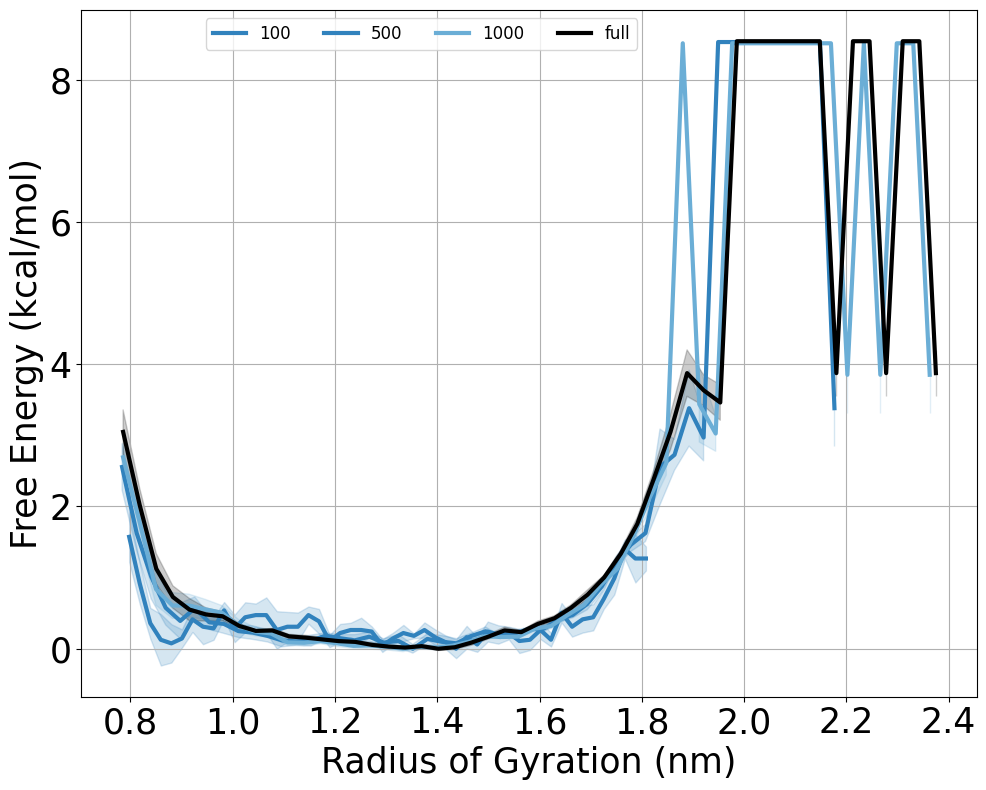

In [50]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [84]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.3501; BF_err ==> 0.0244
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.3806; BF_err ==> 0.0238
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.4324; BF_err ==> 0.0327
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.4417; BF_err ==> 0.0254
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.4438; BF_err ==> 0.0214
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.4519; BF_err ==> 0.0249
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.4517; BF_err ==> 0.0240
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.4456; BF_err ==> 0.0216
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.4468; BF_err ==> 0.0201
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.4463; BF_err ==> 0.0189
Time ==> 1.1 microsec; Total frames ==> 13751; BF ==> 0.4477; BF_err ==> 0.0183
Time ==> 1.2 microsec; Total frames ==> 15001; BF ==> 0.4387; BF_err ==> 0.0174
Time ==> 1.3 microsec; Total frames ==> 16251; 

In [116]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.000244140625, 9.901726806767822e-05)


In [118]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.0013020833333333333, 0.00037979459427024036)
Prob, err : (0.9986979166666666, 0.00037979459427024025)


In [126]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.4386815514993481, 0.012403841603546314


## REST2 protein+Fasudil (20 replicas)

In [127]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/REST2/'
req_dir='data_fas_20'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [128]:
import mdtraj as md

xtc='/data/jaya/work/ANALYSIS_3JAN/rest_1us/rest_xtc_fas_20reps/r/pbc_0.xtc'
pdb='/data/jaya/work/ANALYSIS_3JAN/rest_1us/pbc_fasudil.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428999900817871 nm


In [129]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.0000e+00, 8.0000e-05, 1.6000e-04, ..., 9.9984e-01, 9.9992e-01,
       1.0000e+00])

In [130]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0


/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):


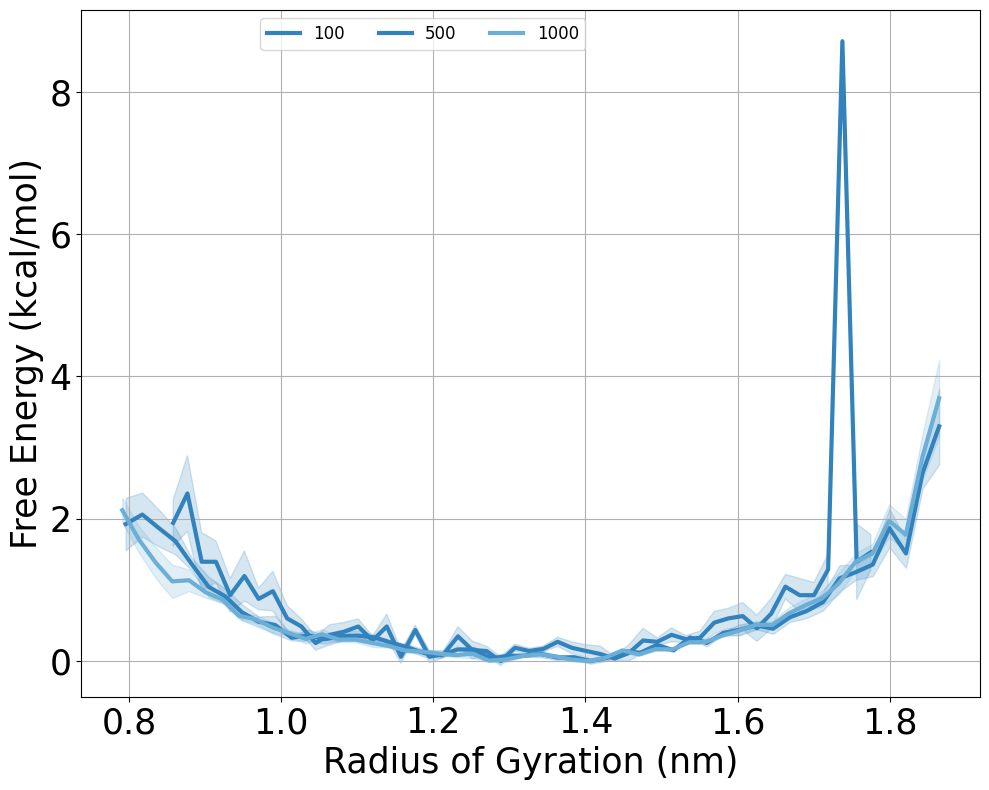

In [131]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

# dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
# sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
# plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [132]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.4277; BF_err ==> 0.0305
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.4322; BF_err ==> 0.0209
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.4122; BF_err ==> 0.0189
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.3855; BF_err ==> 0.0178
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.3812; BF_err ==> 0.0159
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.3915; BF_err ==> 0.0141
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.3873; BF_err ==> 0.0128
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.3862; BF_err ==> 0.0115
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.3902; BF_err ==> 0.0111
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.3948; BF_err ==> 0.0104


In [133]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0003999680025597952, 0.000264882020274808)


In [134]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.0025597952163826892, 0.0010222842798343695)
Prob, err : (0.9974402047836173, 0.0010222842798343697)


In [135]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.3932151736306039, 0.010609282803282334


## REST2 protein+Ligand 47 (10 replicas)

In [136]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/REST2/'
req_dir='data_lig47_10'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [138]:
import mdtraj as md

xtc='/data/jaya/work/ANALYSIS_3JAN/rest_1us/rest_xtc_lig47/r/pbc_0.xtc'
pdb='/data/jaya/work/ANALYSIS_3JAN/rest_1us/pbc_lig47.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428399562835693 nm


In [139]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.99984e+00,
       1.99992e+00, 2.00000e+00])

In [140]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13751 1.1
120 15001 1.2
130 16251 1.3
140 17501 1.4
150 18751 1.5
160 20001 1.6
170 21251 1.7
180 22501 1.8
190 23751 1.9
200 25001 2.0


/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):
/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):
/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):


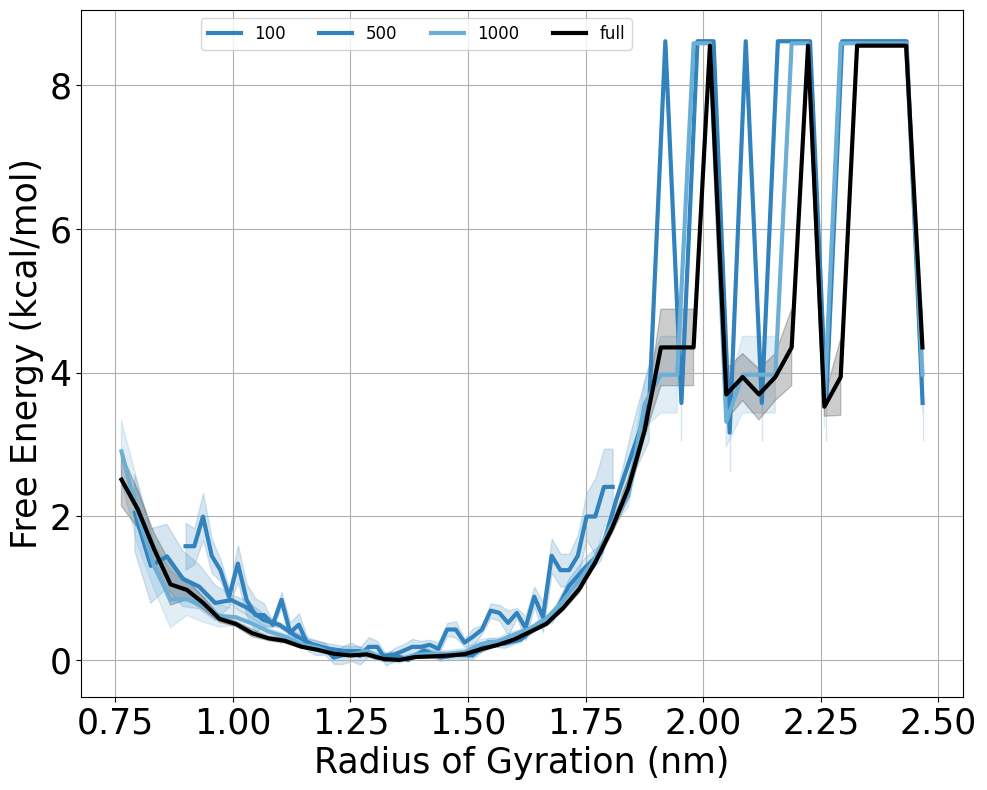

In [141]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [142]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.4548; BF_err ==> 0.0378
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.4778; BF_err ==> 0.0257
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.4532; BF_err ==> 0.0281
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.4545; BF_err ==> 0.0223
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.4662; BF_err ==> 0.0196
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.4895; BF_err ==> 0.0188
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.4956; BF_err ==> 0.0233
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.5001; BF_err ==> 0.0220
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.5032; BF_err ==> 0.0205
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.5177; BF_err ==> 0.0204
Time ==> 1.1 microsec; Total frames ==> 13751; BF ==> 0.5218; BF_err ==> 0.0186
Time ==> 1.2 microsec; Total frames ==> 15001; BF ==> 0.5247; BF_err ==> 0.0173
Time ==> 1.3 microsec; Total frames ==> 16251; 

In [143]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0003199872005119795, 0.0002187982120107835)


In [144]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.002159913603455862, 0.0005493463596293325)
Prob, err : (0.9978400863965441, 0.0005493463596293326)


In [145]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.5063133843748747, 0.0134511878669432


## REST2 protein+Ligand 47 (20 replicas)

In [146]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/REST2/'
req_dir='data_lig47_20'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [147]:
import mdtraj as md

xtc='/data/jaya/work/ANALYSIS_3JAN/rest_1us/rest_xtc_lig47_20reps/r/pbc_0.xtc'
pdb='/data/jaya/work/ANALYSIS_3JAN/rest_1us/pbc_lig47.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428400039672852 nm


In [148]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.00256e+00,
       1.00264e+00, 1.00272e+00])

In [149]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 12535 1.00272


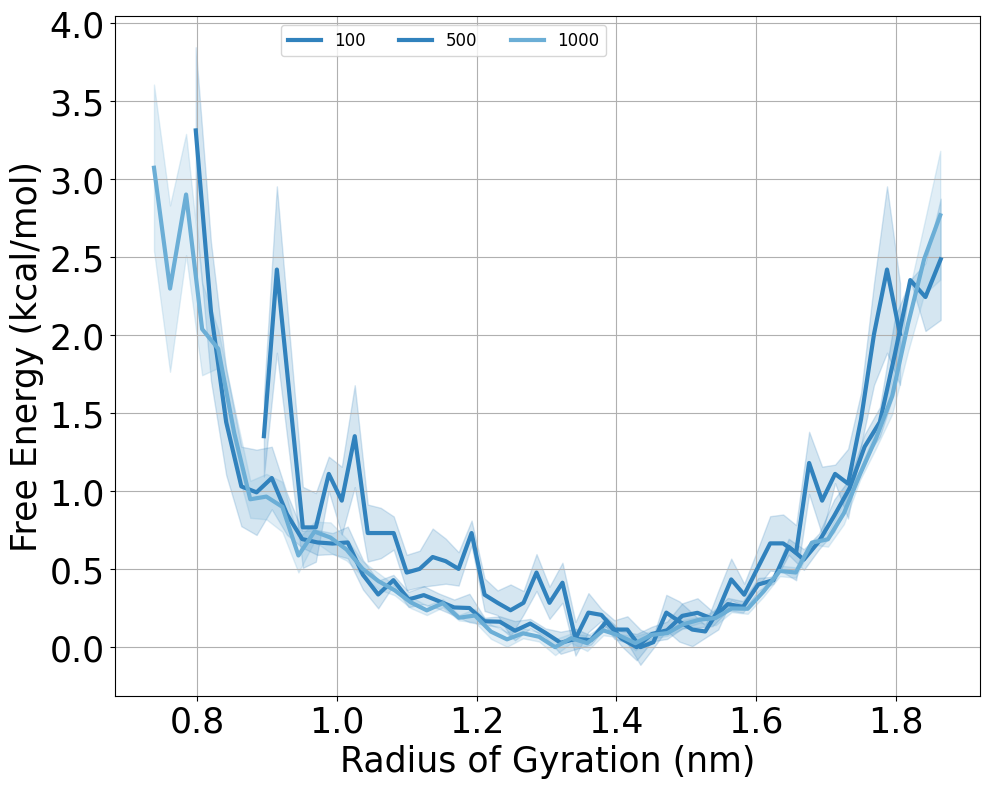

In [151]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

# dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
# sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
# plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [152]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.5516; BF_err ==> 0.0340
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.5494; BF_err ==> 0.0215
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.5572; BF_err ==> 0.0196
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.5447; BF_err ==> 0.0204
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.5225; BF_err ==> 0.0198
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.5297; BF_err ==> 0.0185
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.5314; BF_err ==> 0.0165
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.5310; BF_err ==> 0.0156
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.5244; BF_err ==> 0.0186
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.5216; BF_err ==> 0.0168
Time ==> 1.00272 microsec; Total frames ==> 12535; BF ==> 0.5220; BF_err ==> 0.0168


In [153]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0006382130035899481, 0.00031802497316191024)


In [154]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.002473075388911049, 0.0006329202736699232)
Prob, err : (0.9975269246110889, 0.0006329202736699235)


In [155]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.5207933461292387, 0.013233433226417868


## ssREST3 protein+Fasudil (8 replicas)

In [157]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/ssREST3/'
req_dir='data_fas_8'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [158]:
import mdtraj as md

xtc='/data/jaya/work/REST3/kappa_300K_450K/async_fas_8reps/xtc/r/pbc_0.xtc'
pdb='/data/jaya/work/REST3/kappa_300K_450K/async_fas_8reps/xtc/pbc.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.429200172424316 nm


In [159]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.09056e+00,
       1.09064e+00, 1.09072e+00])

In [160]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13635 1.09072


/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):


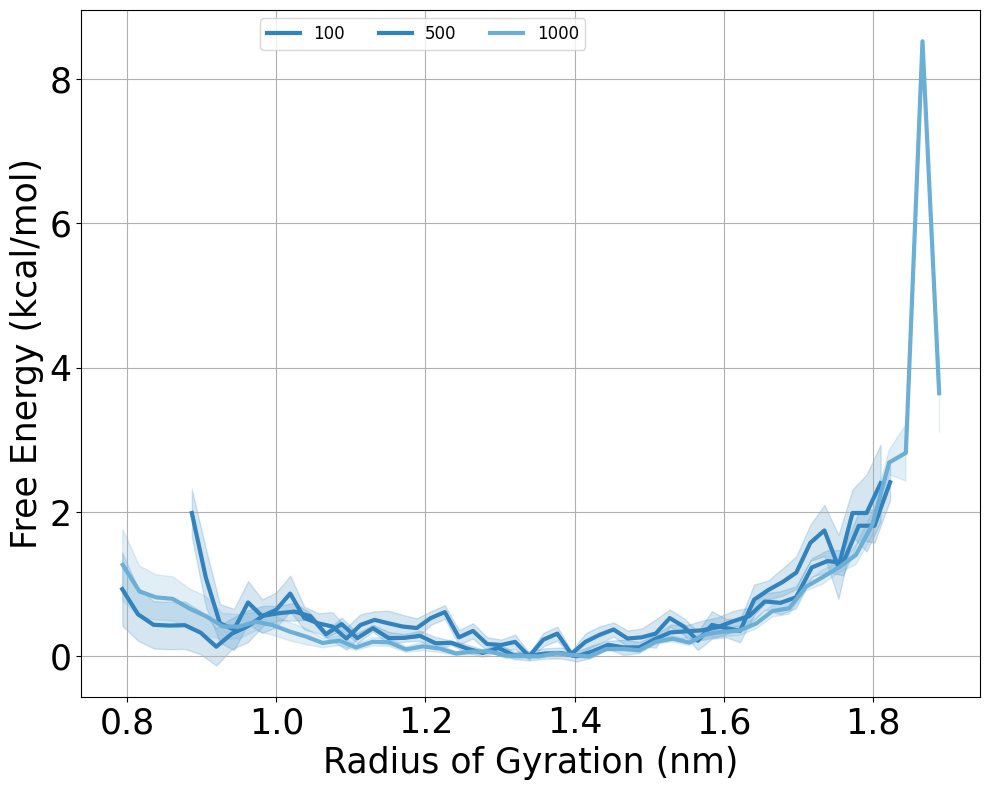

In [161]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

# dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
# sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
# plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [162]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.4860; BF_err ==> 0.0381
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.4390; BF_err ==> 0.0501
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.4007; BF_err ==> 0.0510
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.3935; BF_err ==> 0.0386
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.4054; BF_err ==> 0.0329
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.3957; BF_err ==> 0.0274
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.4085; BF_err ==> 0.0276
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.4102; BF_err ==> 0.0243
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.4179; BF_err ==> 0.0229
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.4066; BF_err ==> 0.0220
Time ==> 1.09072 microsec; Total frames ==> 13635; BF ==> 0.4168; BF_err ==> 0.0233


In [166]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0, 0.0)


In [167]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.00014668133480014669, 0.0001467136150234742)
Prob, err : (0.9998533186651999, 0.0001467136150234742)


In [164]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.4167094549988997, 0.023378953510840524


## ssREST3 protein+Fasudil (16 replicas)

In [168]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/ssREST3/'
req_dir='data_fas_16'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [169]:
import mdtraj as md

xtc='/data/jaya/work/REST3/kappa_300K_450K/async_fas_16reps/xtc/r/pbc_0.xtc'
pdb='/data/jaya/work/REST3/kappa_300K_450K/async_fas_16reps/xtc/pbc.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.429200172424316 nm


In [170]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.45040e+00,
       1.45048e+00, 1.45056e+00])

In [171]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13751 1.1
120 15001 1.2
130 16251 1.3
140 17501 1.4
150 18133 1.45056


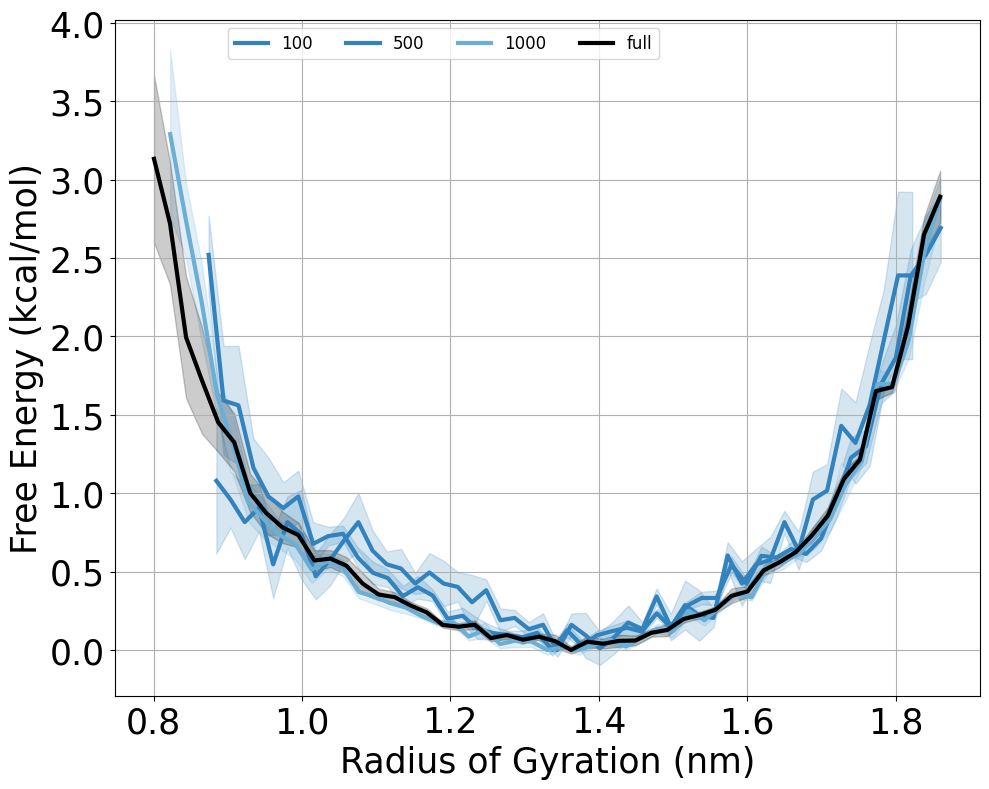

In [172]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [173]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.4181; BF_err ==> 0.0225
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.3786; BF_err ==> 0.0216
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.3919; BF_err ==> 0.0172
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.3785; BF_err ==> 0.0155
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.3875; BF_err ==> 0.0177
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.4099; BF_err ==> 0.0175
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.4132; BF_err ==> 0.0165
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.4015; BF_err ==> 0.0154
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.4022; BF_err ==> 0.0165
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.4035; BF_err ==> 0.0156
Time ==> 1.1 microsec; Total frames ==> 13751; BF ==> 0.4050; BF_err ==> 0.0147
Time ==> 1.2 microsec; Total frames ==> 15001; BF ==> 0.4094; BF_err ==> 0.0147
Time ==> 1.3 microsec; Total frames ==> 16251; 

In [174]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0004963326531737716, 0.00035354469722212673)


In [175]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.0019301825401202228, 0.0009158381532786109)
Prob, err : (0.9980698174598798, 0.0009158381532786109)


In [176]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.4196596308984418, 0.013036935935605511


## ssREST3 protein+Ligand 47 (8 replicas)

In [177]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/ssREST3/'
req_dir='data_lig47_8'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [178]:
import mdtraj as md

xtc='/data/jaya/work/REST3/kappa_300K_450K/async_lig47_8reps/xtc/r/pbc_0.xtc'
pdb='/data/jaya/work/REST3/kappa_300K_450K/async_lig47_8reps/xtc/pbc.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428420543670654 nm


In [179]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.06936e+00,
       1.06944e+00, 1.06952e+00])

In [180]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13370 1.06952


/home/jayakrishna/work/scripts/analysis_class/Block_analysis.py:90: RuntimeWarning: invalid value encountered in divide
  def histo_blockerror(a:np.array, x0:float, xmax:float, bins:int, blocks:int, weights:np.array=None):


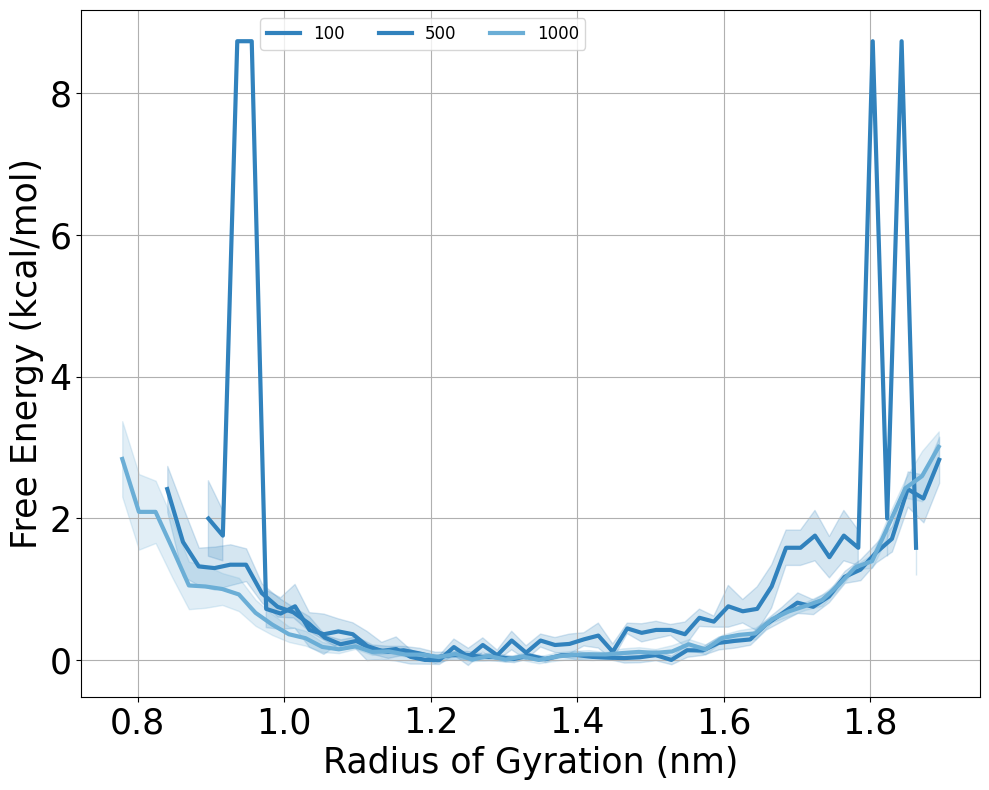

In [182]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

# dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
# sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
# plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [183]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.6443; BF_err ==> 0.0717
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.6234; BF_err ==> 0.0424
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.5367; BF_err ==> 0.0511
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.4921; BF_err ==> 0.0640
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.4956; BF_err ==> 0.0488
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.4969; BF_err ==> 0.0431
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.4983; BF_err ==> 0.0353
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.4975; BF_err ==> 0.0363
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.5088; BF_err ==> 0.0342
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.5105; BF_err ==> 0.0322
Time ==> 1.06952 microsec; Total frames ==> 13370; BF ==> 0.5168; BF_err ==> 0.0299


In [184]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (0.0002243829468960359, 0.00022536057692307688)


In [185]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.0035153328347045623, 0.001512996377295433)
Prob, err : (0.9964846671652955, 0.0015129963772954327)


In [186]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.5150491631014036, 0.028773418572071302


## ssREST3 protein+Ligand 47 (16 replicas)

In [195]:
data_dir='/home/jayakrishna/work/full_data_repo/REST_DATA/ssREST3/'
req_dir='data_lig47_16'

rg=load_json(f'{data_dir}/{req_dir}/rg.json')
cm=load_json(f'{data_dir}/{req_dir}/contact_matrix.json')

# xvg_temp=np.loadtxt(f'{data_dir}/{req_dir}/replica_temp.xvg',comments=['#','@'])
# xvg_index=np.loadtxt(f'{data_dir}/{req_dir}/replica_index.xvg',comments=['#','@'])

l_c=np.sum(cm['rep:0'], 1)

In [196]:
import mdtraj as md

xtc='/data/jaya/work/REST3/kappa_300K_450K/async_lig47_16reps/xtc/r/pbc_0.xtc'
pdb='/data/jaya/work/REST3/kappa_300K_450K/async_lig47_16reps/xtc/pbc.pdb'

traj=md.load_xtc(xtc, pdb, stride=700)
box_len=traj.unitcell_lengths[0][0]

print(f"Box length : {box_len} nm")
del traj

Box length : 6.428420543670654 nm


In [197]:
timestep= 80
time=np.zeros(len(rg['rep:0']))

for i in range(len(rg['rep:0'])):
    time[i]=(i*timestep)/(10**6)

time


array([0.00000e+00, 8.00000e-05, 1.60000e-04, ..., 1.24560e+00,
       1.24568e+00, 1.24576e+00])

In [198]:
magic_num=125
time_split=[]
c=0

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    
    print(i, c, last)

10 1251 0.1
20 2501 0.2
30 3751 0.3
40 5001 0.4
50 6251 0.5
60 7501 0.6
70 8751 0.7
80 10001 0.8
90 11251 0.9
100 12501 1.0
110 13751 1.1
120 15001 1.2
130 15573 1.24576


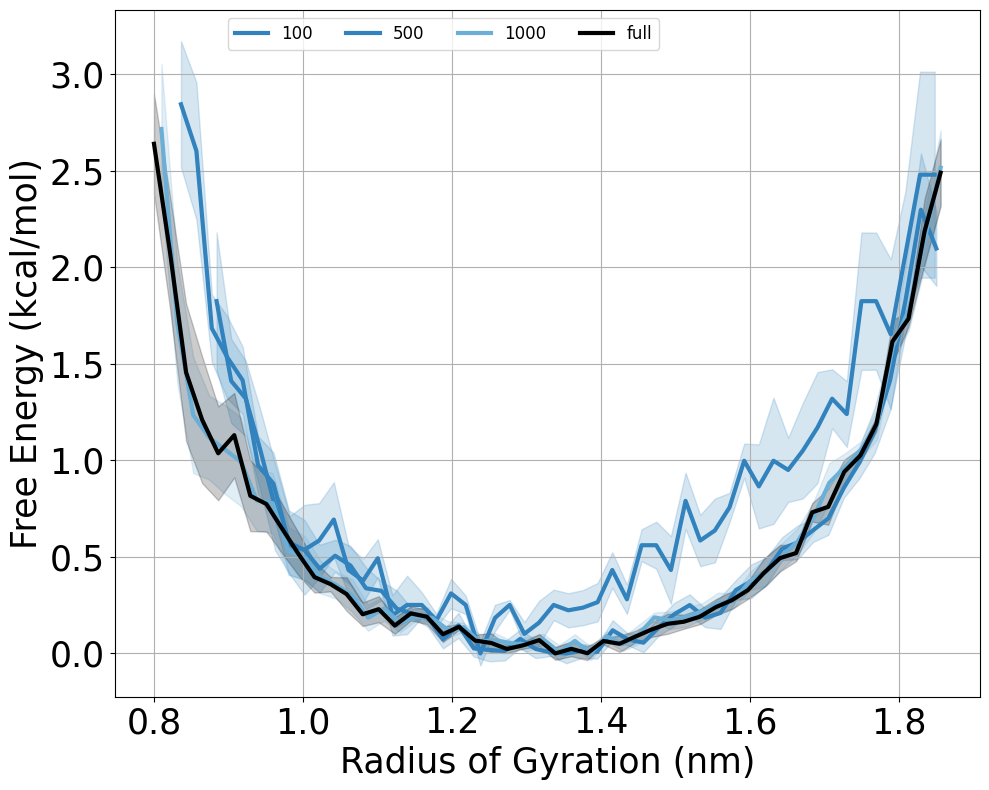

In [199]:
splits=[10, 50, 100]
magic_num=125

plt.figure(figsize=(10,8))

for i in splits :
        
    dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'][:int(magic_num*i)+1], T=300, x0=min(rg['rep:0'][:int(magic_num*i)+1]), xmax=max(rg['rep:0'][:int(magic_num*i)+1]), bins=50, blocks=5, weights=None)
    sns.lineplot(x=bin_centers, y=dG1, color=plt.cm.tab20c(int(i/100)), linewidth=3,label=str(i*10), linestyle='-')
    plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color=plt.cm.tab20c(int(i/100)), alpha=0.2)

dG1, bin_centers, ferr = free_energy_1D_blockerror(rg['rep:0'], T=300, x0=min(rg['rep:0']), xmax=max(rg['rep:0']), bins=50, blocks=5, weights=None)
sns.lineplot(x=bin_centers, y=dG1, color='k', linewidth=3,label='full', linestyle='-')
plt.fill_between(bin_centers, dG1-ferr, dG1+ferr, color='k', alpha=0.2)

# plt.ylim(-0.2, 6)
# plt.xlim(0.5, 2.25)
plt.xlabel('Radius of Gyration (nm)', size=25)
plt.ylabel('Free Energy (kcal/mol)', size=25)
plt.legend(loc='upper center', fontsize=12, ncol=5, bbox_to_anchor=(0.38, 1.0))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.title(f"Replica : {val}", size=20)
plt.tight_layout()
plt.grid()
plt.show()   

In [200]:
magic_num=125
time_split=[]
c=0
K=[]

for i in range(10,510,10):
    c=len(time[:int(magic_num*i)+1])
    last=time[:int(magic_num*i)+1][-1]

    if c in time_split : break

    time_split.append(c)
    kd_bf_data=bound_frac_kd_rw_(box_len,cm['rep:0'][:int(magic_num*i)+1])
    K.append(kd_bf_data)
    
    # print(i, c, last, kd_bf_data[0])
    print(f"Time ==> {last} microsec; Total frames ==> {c}; BF ==> {kd_bf_data[0]:0.4f}; BF_err ==> {kd_bf_data[1]:0.4f}")

K=np.array(K)

Time ==> 0.1 microsec; Total frames ==> 1251; BF ==> 0.4460; BF_err ==> 0.0400
Time ==> 0.2 microsec; Total frames ==> 2501; BF ==> 0.4766; BF_err ==> 0.0264
Time ==> 0.3 microsec; Total frames ==> 3751; BF ==> 0.4788; BF_err ==> 0.0265
Time ==> 0.4 microsec; Total frames ==> 5001; BF ==> 0.4703; BF_err ==> 0.0216
Time ==> 0.5 microsec; Total frames ==> 6251; BF ==> 0.4898; BF_err ==> 0.0195
Time ==> 0.6 microsec; Total frames ==> 7501; BF ==> 0.5097; BF_err ==> 0.0186
Time ==> 0.7 microsec; Total frames ==> 8751; BF ==> 0.5046; BF_err ==> 0.0172
Time ==> 0.8 microsec; Total frames ==> 10001; BF ==> 0.5164; BF_err ==> 0.0194
Time ==> 0.9 microsec; Total frames ==> 11251; BF ==> 0.5177; BF_err ==> 0.0182
Time ==> 1.0 microsec; Total frames ==> 12501; BF ==> 0.5089; BF_err ==> 0.0168
Time ==> 1.1 microsec; Total frames ==> 13751; BF ==> 0.5202; BF_err ==> 0.0164
Time ==> 1.2 microsec; Total frames ==> 15001; BF ==> 0.5190; BF_err ==> 0.0157
Time ==> 1.24576 microsec; Total frames ==> 155

In [201]:
rg_limit=1.0
lc_limit=12

bf_zone=np.zeros(len(rg['rep:0']))
index=0

for rg_t, lc_t in zip(rg['rep:0'], l_c):

    if rg_t < rg_limit and lc_t > lc_limit :
        bf_zone[index]=1 
        # print(f"Rg : {rg_t}; # of contacts : {lc_t}")
    else : bf_zone[index]=0

    index+=1

print(f"Prob, err : {get_blockerror_pyblock_nanskip(bf_zone)}")

Prob, err : (6.421370320426378e-05, 6.430041152263375e-05)


In [202]:
lc_zone_1=np.zeros(len(rg['rep:0']))

for i in np.where(l_c>=12)[0] : lc_zone_1[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_1)}")

lc_zone_2=np.zeros(len(rg['rep:0']))

for i in np.where(l_c<12)[0] : lc_zone_2[i]=1 

print(f"Prob, err : {get_blockerror_pyblock_nanskip(lc_zone_2)}")

Prob, err : (0.0017979836897193862, 0.0009649700664194506)
Prob, err : (0.9982020163102806, 0.0009649700664194506)


In [203]:
cm_zone_1=[]

for i in np.where(l_c>=12)[0] : cm_zone_1.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_1)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_1)[1]}")

cm_zone_2=[]

for i in np.where(l_c<12)[0] : cm_zone_2.append(cm['rep:0'][i])

print(f"Prob, err : {bound_frac_kd_rw_(box_len,cm_zone_2)[0]}, {bound_frac_kd_rw_(box_len,cm_zone_2)[1]}")

Prob, err : 1.0, 0.0
Prob, err : 0.5163074943711804, 0.015189321145476987
